[1.35145799e-04 6.08265115e-04 5.02461172e-03 2.43572073e-02
 3.78174514e-02 1.65724421e-02 2.09244410e-03 8.20042025e-05
 1.34425185e-06 1.43140175e-08]


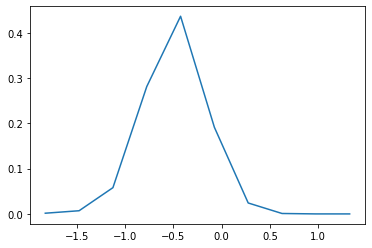

41.84693264961243


In [12]:
# Test of stable single-cell system, using drag lifetime from JASON model

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = [575, 625] # altitude band of Starlink satellites (km)
V = 4*np.pi*50*(R+600)**2 # volume of band
S_i = [0]
S_di = [0]
D_i = [0]
N_i = int(2.5e-8*V)
lam = 1000
T = 50
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = int(t*12) % 144
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell([S_i], [S_di], [D_i], [N_i], [600], alt, [lam], drag_lifetime_loc, need_update, chi_max=1.5)
print(np.sum(atmosphere.sat_coll_probability_tables[0][0], axis=0))
chi_edges = np.linspace(-2.0, 1.5, num=11)
chi_ave = []
for i in range(0, 10):
    chi_val = (chi_edges[i] + chi_edges[i+1])/2
    chi_ave.append(chi_val)
plt.plot(chi_ave, np.sum(atmosphere.sat_coll_probability_tables[0][0], axis=0)/np.sum(atmosphere.sat_coll_probability_tables[0]))
plt.show()

x = time()
atmosphere.run_sim_euler(T, dt=0.001)
print(time() - x)
#atmosphere.run_sim_precor(T, dt=1, mindtfactor=1000, tolerance=2)

In [40]:
# multi-cell probability table

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = np.linspace(300,1200,num=21)
S_i = [[0]]*20
S_di = [[0]]*20
D_i = [[0]]*20
N_i = [0]*20
lam = 1000
T = 50
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = int(t*12) % 144
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell(S_i, S_di, D_i, N_i, [600], alt, [lam], drag_lifetime_loc, need_update, num_chi=1, num_L=1, num_dir=1000, chi_max=0.5)
print(atmosphere.logL_edges, atmosphere.chi_edges)
print(np.sum(atmosphere.sat_expl_probability_tables[0]))

[-3.  0.] [-2.   0.5]
0.7309549545926599


[0.02552039 0.02899443 0.038028   0.05453657 0.07924972 0.12347857
 0.21744624 0.12652399 0.08126423 0.0545219  0.04274121 0.02879869
 0.02336708 0.01904301 0.01362998 0.01187297 0.00999953 0.0083871
 0.0066468  0.00594959]
0.8740493862666937


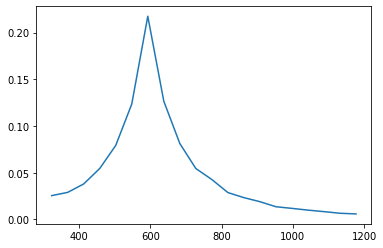

In [41]:
print(np.sum(atmosphere.sat_coll_probability_tables[6], axis=(1,2))/np.sum(atmosphere.sat_coll_probability_tables[6]))
data = np.sum(atmosphere.sat_coll_probability_tables[6], axis=(1,2))/np.sum(atmosphere.sat_coll_probability_tables[6])
print(np.sum(atmosphere.sat_coll_probability_tables[6]))
x_axis = []
for i in range(20):
    x_axis.append((alt[i]+alt[i+1])/2)
plt.plot(x_axis, data)
plt.show()

In [20]:
import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
from BreakupModel import vprime_cdf
import matplotlib.pyplot as plt
import numpy as np

num_dir=200
chi = 0.0
Re = 6371 # radius of earth in km
G = 6.67430e-11 # gravitational constant (N*m^2/kg^2)
Me = 5.97219e24 # mass of Earth (kg)
alt_edges = np.linspace(300,1200,num=101)
dh = alt_edges[1]-alt_edges[0]
alts = np.zeros(100)
for i in range(len(alt_edges)-1):
    alts[i] = (alt_edges[i] + alt_edges[i+1])/2
v_orbits = np.sqrt(G*Me/((Re + alts)*1000))/1000 # orbital velocity in km/s
probs = np.zeros(len(alts)) # probability distribution

v0 = v_orbits[int(len(alts)/3)]*1000 # orbital velocity in m/s
r = alts[int(len(alts)/3)] # in km
print(r)
#theta_P = np.linspace(0, 1, num=num_dir) # random directions
phi = np.linspace(0, 2*np.pi, num=num_dir)
theta = np.linspace(0, np.pi, num=num_dir)
#theta = np.arccos(1.0-2.0*theta_P)
for i in range(len(alts)): # iterate through altitudes
    alt_min = alts[i] - dh/2 # in km
    alt_max = alts[i] + dh/2
    v_min2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_min)*1000)) # minimum velocity squared (m/s)
    v_max2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_max)*1000)) # maximum velocity squared (m/s)
    if i == 0 : print(np.sqrt(v_min2))
    if i == len(alts)-1 : print(np.sqrt(v_max2))
    sum = 0
    for j in range(num_dir): # sample random directions
        sum_loc = 0
        for k in range(num_dir):
            if v_min2 < 0 and v_max2 < 0 : pass
            elif v_min2 < 0 : sum_loc += vprime_cdf(np.sqrt(v_max2), v0, theta[j], phi[k], chi, 'expl')
            else : sum_loc += vprime_cdf(np.sqrt(v_max2), v0, theta[j], phi[k], chi, 'expl') - vprime_cdf(np.sqrt(v_min2), v0, theta[j], phi[k], chi, 'expl')
        sum_loc *= np.sin(np.pi/(num_dir-1)*j)
        sum += sum_loc
    probs[i] = sum*np.pi/(2*(num_dir-1)**2)

601.5
7388.097344273115
7854.101759879091


0.9469966312153526


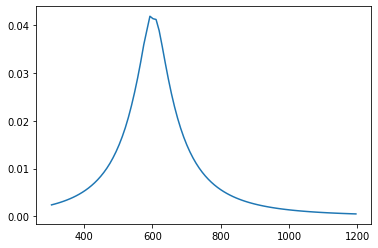

In [21]:
print(np.sum(probs))
plt.plot(alts, probs)
plt.show()

In [4]:
import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
from BreakupModel import vprime_cdf
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import dblquad

chi = 0.5
Re = 6371 # radius of earth in km
G = 6.67430e-11 # gravitational constant (N*m^2/kg^2)
Me = 5.97219e24 # mass of Earth (kg)
alt_edges = np.linspace(300,1200,num=101)
dh = alt_edges[1]-alt_edges[0]
alts = np.zeros(100)
for i in range(len(alt_edges)-1):
    alts[i] = (alt_edges[i] + alt_edges[i+1])/2
v_orbits = np.sqrt(G*Me/((Re + alts)*1000))/1000 # orbital velocity in km/s
probs = np.zeros(len(alts)) # probability distribution

v0 = v_orbits[int(len(alts)/3)]*1000 # orbital velocity in m/s
r = alts[int(len(alts)/3)] # in km

def local_func(theta, phi, v_max2, v_min2):
    if v_min2 < 0 and v_max2 < 0 : return 0
    elif v_min2 < 0 : return np.sin(theta)*vprime_cdf(np.sqrt(v_max2), v0, theta, phi, chi, 'coll')
    else : return np.sin(theta)*(vprime_cdf(np.sqrt(v_max2), v0, theta, phi, chi, 'coll') - vprime_cdf(np.sqrt(v_min2), v0, theta, phi, chi, 'coll'))
print(r)
for i in range(len(alts)): # iterate through altitudes
    alt_min = alts[i] - dh/2 # in km
    alt_max = alts[i] + dh/2
    v_min2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_min)*1000)) # minimum velocity squared (m/s)
    v_max2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_max)*1000)) # maximum velocity squared (m/s)
    if i == 0 : print(np.sqrt(v_min2))
    if i == len(alts)-1 : print(np.sqrt(v_max2))
    probs[i] = dblquad(local_func, 0, 2*np.pi, 0, np.pi, args=(v_max2,v_min2), epsabs=1e-3)[0]/(4*np.pi)

601.5
7388.097344273115


/home/justin/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


7854.101759879091


0.15583858549333357


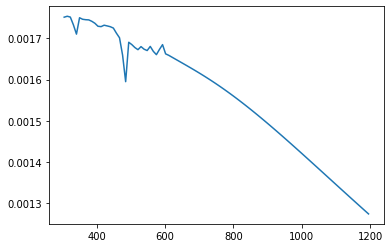

In [5]:
print(np.sum(probs))
plt.plot(alts, probs)
plt.show()

In [35]:
import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
from BreakupModel import vprime_cdf
import matplotlib.pyplot as plt
import numpy as np

num_dir=1000
chi = -0.5
Re = 6371 # radius of earth in km
G = 6.67430e-11 # gravitational constant (N*m^2/kg^2)
Me = 5.97219e24 # mass of Earth (kg)
alt_edges = np.linspace(300,1200,num=21)
dh = alt_edges[1]-alt_edges[0]
alts = np.zeros(20)
for i in range(len(alt_edges)-1):
    alts[i] = (alt_edges[i] + alt_edges[i+1])/2
v_orbits = np.sqrt(G*Me/((Re + alts)*1000))/1000 # orbital velocity in km/s
probs = np.zeros(len(alts)) # probability distribution

v0 = v_orbits[int(len(alts)/3)]*1000 # orbital velocity in m/s
r = alts[int(len(alts)/3)] # in km
print(r)
phi = np.random.rand(num_dir)*2*np.pi
theta = np.random.rand(num_dir)*np.pi
for i in range(len(alts)): # iterate through altitudes
    alt_min = alts[i] - dh/2 # in km
    alt_max = alts[i] + dh/2
    v_min2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_min)*1000)) # minimum velocity squared (m/s)
    v_max2 = G*Me*(2/((Re + r)*1000) - 1/((Re + alt_max)*1000)) # maximum velocity squared (m/s)
    if i == 0 : print(np.sqrt(v_min2))
    if i == len(alts)-1 : print(np.sqrt(v_max2))
    sum = 0
    for j in range(num_dir): # sample random directions
        if v_min2 < 0 and v_max2 < 0 : pass
        elif v_min2 < 0 : sum += np.sin(theta[j])*vprime_cdf(np.sqrt(v_max2), v0, theta[j], phi[j], chi, 'coll')
        else : sum += np.sin(theta[j])*(vprime_cdf(np.sqrt(v_max2), v0, theta[j], phi[j], chi, 'coll') - vprime_cdf(np.sqrt(v_min2), v0, theta[j], phi[j], chi, 'coll'))
    probs[i] = sum/num_dir

592.5
7398.091347786311
7863.503524274092


0.4495157454684269


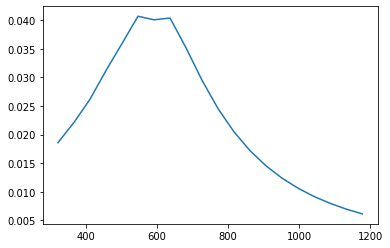

In [36]:
print(np.sum(probs))
plt.plot(alts, probs)
plt.show()

In [1]:
# Test of stable single-cell system, using drag lifetime from JASON model

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = [575, 625] # altitude band of Starlink satellites (km)
V = 4*np.pi*50*(R+600)**2 # volume of band
S_i = [0]
S_di = [0]
D_i = [0]
N_i = int(2.5e-8*V)
lam = 1000
T = 30
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = t*12
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell([S_i], [S_di], [D_i], [N_i], [600], alt, [lam], drag_lifetime_loc, need_update, num_dir=1000)
x = time()
atmosphere.run_sim_euler(T, dt=0.001)
print(time() - x)

1.0
0.0
0.0
[[5106.69164769    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [1690.98453237    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 559.93760461    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 185.41276698    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [  61.39593747    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [  20.33010563    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   6.73193068    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 362.17115706    0.        

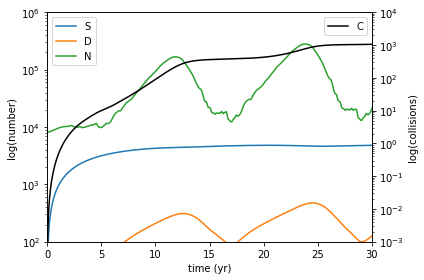

In [2]:
t = atmosphere.get_t()
S = atmosphere.get_S()[0][0]
SD = atmosphere.get_SD()[0][0]
D = atmosphere.get_D()[0][0]
N = atmosphere.get_N()[0]
C = atmosphere.get_C()[0]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('time (yr)')
ax1.set_ylabel('log(number)')
ax1.set_yscale('log')
ax1.plot(t, S, label='S')
ax1.plot(t, D, label='D')
ax1.plot(t, N, label='N')
ax1.set_ylim(100, 1e6)
ax1.set_xlim(0,30)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('log(collisions)')  # we already handled the x-label with ax1
ax2.plot(t, C, label='C', color='k')
ax2.set_ylim(1e-3, 1e4)
ax2.set_yscale('log')
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()